<a href="https://colab.research.google.com/github/yiyichanmyae/time_series/blob/main/4_rnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0
Epoch 1/100
31/31 [==============================] - 4s 28ms/step - loss: 0.1788 - mae: 0.1788
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 0.1529 - mae: 0.1529
Epoch 3/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1483 - mae: 0.1483
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 0.1473 - mae: 0.1473
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 0.1473 - mae: 0.1473
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 0.1458 - mae: 0.1458
Epoch 7/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1466 - mae: 0.1466
Epoch 8/100
31/31 [==============================] - 1s 25ms/step - loss: 0.1451 - mae: 0.1451
Epoch 9/100
31/31 [==============================] - 1s 30ms/step - loss: 0.1455 - mae: 0.1455
Epoch 10/100
31/31 [==============================] - 1s 39ms/step 

array([60.932762, 60.970856, 61.121452, 61.019825, 61.013447, 61.135754,
       60.842064, 60.91199 , 61.0312  , 61.0024  , 60.980896, 61.212086,
       61.027855, 61.074116, 61.108646, 61.02691 , 60.792282, 60.922398,
       61.05407 , 60.926743, 60.831535, 60.88515 , 60.97837 , 61.054462,
       60.90564 , 60.936874, 60.88006 , 60.90755 , 60.858402, 61.03255 ,
       60.82643 , 60.94874 , 60.716217, 61.042995, 60.7626  , 60.942207,
       61.03396 , 61.013897, 60.994278, 60.910873, 60.89963 , 61.0172  ,
       60.955154, 60.686283, 60.741486, 60.90077 , 60.941673, 60.93099 ,
       60.87465 , 61.05331 , 60.96749 , 61.120174, 60.892906, 60.861713,
       60.9856  , 60.739445, 61.063866, 61.088413, 60.90211 , 60.808502,
       60.71146 , 60.971096, 60.797054, 60.921486, 60.934525, 60.81873 ,
       60.83746 , 61.08372 , 60.723946, 60.736046, 60.974056, 60.85851 ,
       60.845078, 60.870758, 60.95888 , 60.970486, 60.899124, 60.748314,
       60.82966 , 60.930466, 60.800774, 61.188366, 

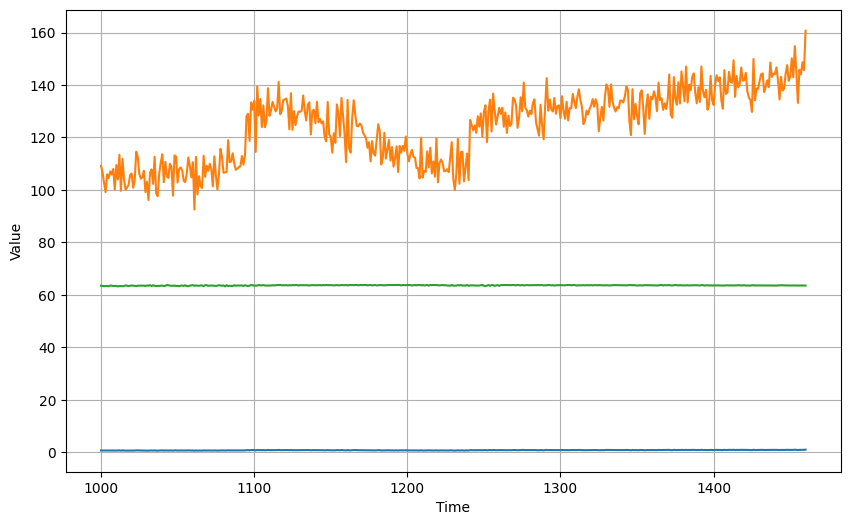

In [13]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return time * slope

def seasonality(time, period, amplitude=1, phase=0):
  """ """
  season_time =((time + period) % period) / period
  return amplitude * seasonal_pattern(season_time)

def seasonal_pattern(season_time):
  """Just an arbitrary pattern"""
  return np.where(
      season_time < 0.4,
      np.cos(season_time * 2 * np.pi),
      1/np.exp(3* season_time)
  )

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 +1, dtype="float32")
baesline = 10
series = trend(time, 0.1)
baseline  = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

min = np.min(series)
max = np.max(series)

series -= min
series /= max
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size +1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1)

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

scaled_xvalid = x_valid*max
scaled_xvalid = scaled_xvalid+min
scaled_forecast = forecast*max
scaled_forecast = scaled_forecast+min

plot_series(time_valid, scaled_xvalid)
plot_series(time_valid, scaled_forecast)

print(max)

tf.keras.metrics.mean_absolute_error(scaled_xvalid, scaled_forecast).numpy()

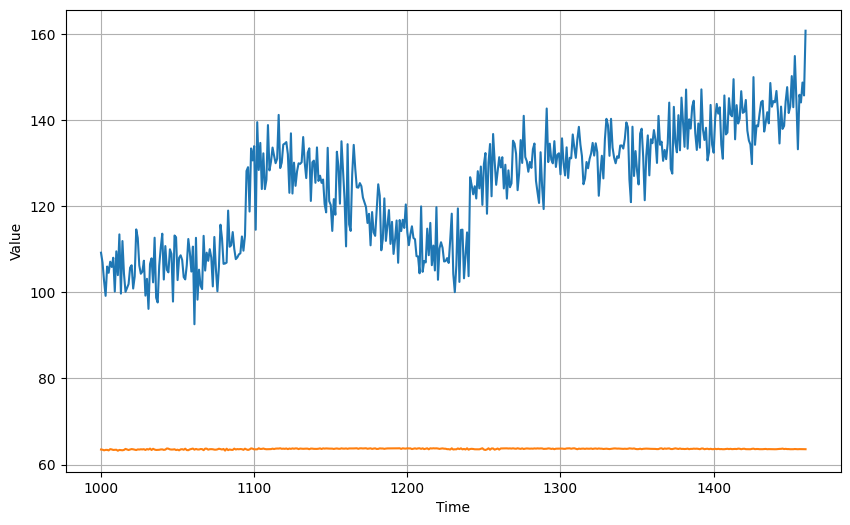

In [15]:
plt.figure(figsize=(10, 6))
scaled_xvalid = x_valid*max
scaled_xvalid = scaled_xvalid+min
scaled_forecast = forecast*max
scaled_forecast = scaled_forecast+min

plot_series(time_valid, scaled_xvalid)
plot_series(time_valid, scaled_forecast)